# Week 6
# Multilinear Regression

**Reference: Chapter 4**

Last time we looked at a simple linear regression model $sales = \beta_0 + \beta_1\cdot\textit{TV advertising budget}$. More generally, a linear model makes a prediction by computing a weighted sum of their input features (plus a constant).

## Multilinear Regression: Model Assumptions
**Model**:

$\hat{y} = \theta_0 + \theta_1x_1 + \theta_2x_2 +\cdots + \theta_nx_n$
1. $\hat{y}$ is the predicted value.
2. $n$ is the number of features.
3. $x_i$ is the i-th feature value.
4. $\theta_j$ is the j-th model parameter (associated with $x_j$).

**Vectorized form**:

**$\hat{y} = \textbf{x}\cdot\theta^T$**.
1. $\theta = (\theta_0, \theta_1, ..., \theta_n)$ is the paramter vector.
2. $\textbf{x} = (1, x_1, ..., x_n)$ is the feature vector.

**MSE (mean squared error) Cost function**:

$J = \frac{1}{m}\sum_{i=1}^{m}\big(\textbf{x}^{(i)}\cdot\theta^T - y^{(i)}\big)^2$

Here $(\textbf{x}^{(i)}, y^{(i)})$ represents the i-th training example


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Toy example
columns = ['Homework', 'Midterm', 'Final']
data = pd.DataFrame({
    "Homework": [95, 70, 80, 100, 70],
    "Midterm": [90, 60, 80, 80, 85],
    "Final": [93, 66, 85, 60, 90]
}, index=["Alice", "Bob", "Clare", "David", "Eve"])

data.head()

,Homework,Midterm,Final
Alice,95,90,93
Bob,70,60,66
Clare,80,80,85
David,100,80,60
Eve,70,85,90


In this case:
- $x_1$ is the homework feature
- $x_2$ is the midterm feature
- $y$ is the final feature
- model is: $final = \theta_0 + \theta_1 * homework + \theta_2 * midterm$
- We need to come up with values for $\theta_0, \theta_1, \theta_2$ to complete the model.

**Objective**: Suppose that another student Fred has Homework score 85 and Midterm score 80. What is prediction of his final exam score?

## Trial and Error
Before studying the algorithms that give the best fit, let's see how well we can learn the model ourselves. Let's take the following approach:

1. Calculate the correlation coefficients of variable pair (Homework, Final) and (Midterm, Final)
2. Distribute weight to homework and final proportional to their correlation coefficients. For example, if the value are the same for both pairs, then both the term homework and midterm should have parameter value 0.5.
3. Calculate the value of $\theta_0$ so that Alice's data fits the model exactly.

In [3]:
# Calculate the correlation coefficient between homework and final using np.corrcoef()
print(np.corrcoef(data['Homework'], data['Final'])[0, 1])

# Calculate the correlation coefficient between midterm and final
print(np.corrcoef(data['Midterm'], data['Final'])[0, 1])

-0.1771490677357476
0.6700743886411277


In [4]:
# Distribute weight to homework and midterm according to their correlation coefficients.
theta1 = 0.2
theta2 = 0.8

We have chosen values for $\theta_1$ and $\theta_2$, now we need a value for $\theta_0$.

In [5]:
# Solve for theta0 so that if homework=95 and midterm=90, final=93.
theta0 = 93 - 0.2 * 95 - 0.8 * 90
print(theta0)

2.0


Our guess of the model: $final = 2 + 0.2\times homework + 0.8\times midterm$.

Now, let's calculate the average error the model makes on the data.

In [6]:
# Calculate the MSE (mean-squared-error)

# 1. calculate the squared error for the first instance
# x1 = np.array([95, 90])
x1 = data.loc["Alice", ['Homework', "Midterm"]].values
print(x1)
# y1 = np.array([93])
y1 = data.loc["Alice", ['Final']].values
print(y1)
theta = np.array([2.0, 0.2, 0.8])
print(theta)
prediction = 2.0 + 0.2 * x1[0] + 0.8 * x1[1]
squared_error = (prediction - y1) ** 2
print("Squared error for Alice:", squared_error)

[95 90]
[93]
[2.  0.2 0.8]
Squared error for Alice: [0.]


In [7]:
# 2. define a function that returns the error of a given instance.
def get_squared_error(data, name, theta):
    # Extract x and y from data
    x = data.loc[name, ['Homework', 'Midterm']].values
    y = data.loc[name, ['Final']].values
    # calculate prediction
#     prediction = 2.0 + 0.2*x[0]+0.8*x[1]
    prediction = theta[0] + theta[1]*x[0] + theta[2]*x[1]
    # calculate the squared error
    squared_error = (prediction - y)**2
    return squared_error

get_squared_error(data, "Bob", theta)

array([4.])

In [8]:
# 3. calculate all errors
all_errors = [get_squared_error(data,name,theta) for name in data.index]
print(all_errors)

# 4. calculate the average.
mse = np.mean(all_errors)
print("MSE:", mse)
print("Root mean squared error (RMSE):", np.sqrt(mse))

[array([0.]), array([4.]), array([9.]), array([676.]), array([36.])]
MSE: 145.0
Root mean squared error (RMSE): 12.041594578792296


## Multilinear Regression: Normal Equation
The value of $\theta$ that minimizes the cost function is:

$\hat{\theta} = \big(\textbf{X}^T\cdot\textbf{X}\big)^{-1}\cdot\textbf{X}^T\cdot\textbf{y}$.

1. $\textbf{X}$ is an $m\times (n+1)$ matrix whose i-th row is $\textbf{x}^{(i)}$.
$$\textbf{X} = \begin{pmatrix}
1 & x^{(1)}_1 & x^{(1)}_2 & \cdots & x^{(1)}_n \\
1 & x^{(2)}_1 & x^{(2)}_2 & \cdots & x^{(2)}_n \\
\vdots & \vdots &\vdots & \ddots & \vdots \\
1 & x^{(m)}_1 & x^{(m)}_2 & \cdots & x^{(m)}_n \\
\end{pmatrix}$$
2. $$\textbf{y} = \begin{pmatrix}y^{(1)} \\ \vdots \\ y^{(m)}\end{pmatrix}$$.
3. The cost function $J(\theta)$ also has a matrix expression
$$J(\theta) = \frac{1}{m}(\textbf{X}^T\cdot\theta - \textbf{y})^T\cdot (\textbf{X}^T\cdot\theta - \textbf{y})$$

In [9]:
# Construct matrix X using np.hstack(), np.ones()
m, n = data.shape
X = np.hstack([np.ones([m, 1]), data[['Homework', 'Midterm']].values])
print(X)

[[  1.  95.  90.]
 [  1.  70.  60.]
 [  1.  80.  80.]
 [  1. 100.  80.]
 [  1.  70.  85.]]


In [10]:
# Construct vector y
y = data[['Final']].values
print(y)

[[93]
 [66]
 [85]
 [60]
 [90]]


In [11]:
# Apply the normal equation to find theta
num = X.T.dot(X)
theta_opt = np.linalg.inv(num).dot(X.T.dot(y))
print(theta_opt)

[[35.        ]
 [-0.71627907]
 [ 1.30697674]]


In [12]:
# Find the MSE of the optimal model
all_errors = [get_squared_error(data, name, theta_opt) for name in data.index]
mse = np.mean(all_errors) # mean squared error
rmse = np.sqrt(mse) # root mean squared error
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 36.82790697674422
RMSE: 6.068600083770903


## Multilinear Regression: Gradient Descent
The normal equation is not applicable when $\textbf{X}^T\cdot\textbf{X}$ is not invertible. It happens if:
- Several features are linearly dependent (for example, feature3 = feature1 + feature2)
- The number of features is greater than the number of training data (for example, DNA data)

In this case, we can use the **gradient descent** method to minimize the cost function.

Gradient descent is an iterative algorithm for finding the **local minimum** of a differentiable function.
- Choose an initial value of $\hat{\theta}$ and a **learning rate** $r$.
- For each iteration $k$, do:
$$\hat{\theta} \leftarrow \hat{\theta} - r\cdot\frac{\partial J(\hat{\theta})}{\partial \theta}.$$
- The partial derivative of the cost function is given by
$$
\frac{\partial J(\hat{\theta})}{\partial \theta} = \frac{2}{m}\cdot\textbf{X}^T\cdot(\textbf{X}\cdot\theta - \textbf{y}).
$$
- **Verify the formula of partial derivative asuuming there is one input feature.**

- End iteration if certain stop criteria is reached, such as:
    - Value of $\hat{\theta}$ becomes stable.
    - Certain iteration amount is reached.

In [13]:
# Choose a random initial value
m, n = data.shape
theta_hat = np.random.rand(n, 1)
# print(theta_hat)

# # normalize the input values so that numbers are between 0 and 1.
X2 = np.hstack([np.ones([m, 1]), data[['Homework', 'Midterm']].values/100])
y2 = y
# print(X2)

num_iter = 6000
r = 0.05

MSEs = []
for iter in range(num_iter):
    # Calculate the gradient
    gradient = (X2.T).dot(X2.dot(theta_hat)-y2)*2/m
                          
    # Update the parameters
    theta_hat -=  r * gradient
    
    # Calculate the MSE
    MSE = 1/m * (X2.dot(theta_hat) - y2).T.dot(X2.dot(theta_hat) - y2)
    
    # Append the MSE to the list MSEs
    MSEs.append(MSE[0, 0])
    
print(theta_hat)

[[ 36.30348109]
 [-69.95455806]
 [127.2982388 ]]


In [14]:
MSE

array([[36.92014453]])

(0, 200)

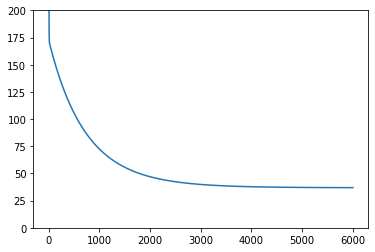

In [15]:
plt.plot(range(num_iter), MSEs)
plt.ylim(0, 200)

**Discussion**
1. Change $r$ to 0.000001 and 1. Observe the MSE curve.
2. Does the initial point matter?
3. How to determine when to stop the iteration?

### Multilinear Regression via `sklearn.linear_model.LinearRegression`
- fit(): train the model
- predict(): make predictions
- coef_: variable coefficients
- intercept_: model intercept

In [16]:
# Build a linear regression model using LinearRegression from sklearn.linear_model
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(data[['Homework', 'Midterm']], data['Final'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
# Show the parameter values
model_lr.intercept_, model_lr.coef_

(35.00000000000004, array([-0.71627907,  1.30697674]))

# Homework

Apply multilinear regression model on the advertising data used in the previous notebook. Train the model in two ways:

1. Use `LinearRegression` class from `sklearn.linear_model`.
2. Use the normal equation.

Split the data into 80% training data and 20% test data. Show the paramter values and the MSEs on the training set and the test set (Hint: use either the formula given in class today or use `mean_squared_error` function from `sklearn.metrics`)